In [132]:
import json

import pandas as pd
import altair as alt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from preprocessing import MinMaxScaler
#from sklearn.pipeline import Pipeline
#from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [3]:
# load data
boardgame_data = pd.read_csv('board_games.csv', parse_dates=['year_published'])
boardgame_data['year_published'] = pd.to_datetime(boardgame_data['year_published'], format='%Y')

In [4]:
# convert NA values for these features to a value
values = {'category': 'Unknown', 'family': 'Unknown', 'mechanic': 'Unknown', 'publisher': 'Unknown'}
boardgame_data.fillna(value = values, inplace = True)
# convert multi-values to lists
column_list = ['category', 'mechanic', 'family', 'publisher']
boardgame_data[column_list] = boardgame_data[column_list].apply(lambda x: x.str.split(","))

In [5]:
boardgame_data.head()

,game_id,description,image,max_players,max_playtime,min_age,min_players,min_playtime,name,playing_time,...,artist,category,compilation,designer,expansion,family,mechanic,publisher,average_rating,users_rated
0,1,Die Macher is a game about seven sequential po...,//cf.geekdo-images.com/images/pic159509.jpg,5,240,14,3,240,Die Macher,240,...,Marcus Gschwendtner,"[Economic, Negotiation, Political]",NaN,Karl-Heinz Schmiel,NaN,"[Country: Germany, Valley Games Classic Line]","[Area Control / Area Influence, Auction/Biddin...","[Hans im Glück Verlags-GmbH, Moskito Spiele, V...",7.66508,4498
1,2,Dragonmaster is a trick-taking card game based...,//cf.geekdo-images.com/images/pic184174.jpg,4,30,12,3,30,Dragonmaster,30,...,Bob Pepper,"[Card Game, Fantasy]",NaN,"G. W. ""Jerry"" D'Arcey",NaN,[Animals: Dragons],[Trick-taking],"[E.S. Lowe, Milton Bradley]",6.60815,478
2,3,"Part of the Knizia tile-laying trilogy, Samura...",//cf.geekdo-images.com/images/pic3211873.jpg,4,60,10,2,30,Samurai,60,...,Franz Vohwinkel,"[Abstract Strategy, Medieval]",NaN,Reiner Knizia,NaN,"[Asian Theme, Country: Japan, Knizia tile-layi...","[Area Control / Area Influence, Hand Managemen...","[999 Games, ABACUSSPIELE, Astrel Games, Ceilik...",7.44119,12019
3,4,When you see the triangular box and the luxuri...,//cf.geekdo-images.com/images/pic285299.jpg,4,60,12,2,60,Tal der Könige,60,...,NaN,[Ancient],NaN,Christian Beierer,NaN,"[Country: Egypt, Promotional Board Games]","[Action Point Allowance System, Area Control /...",[KOSMOS],6.60675,314
4,5,"In Acquire, each player strategically invests ...",//cf.geekdo-images.com/images/pic342163.jpg,6,90,12,3,90,Acquire,90,...,"Scott Okumura,Peter Whitley",[Economic],NaN,Sid Sackson,NaN,[3M Bookshelf Series],"[Hand Management, Stock Holding, Tile Placement]","[3M, Avalon Hill, Avalon Hill (Hasbro), Dujard...",7.35830,15195


In [6]:
# create subset of data features for clustering
# note that 'family' is not currently included due to the high number of values (creates a very large matrix when)
boardgame_data_sub = boardgame_data.copy()
boardgame_data_sub = boardgame_data_sub[['game_id', 'name', 'category', 'compilation', 'expansion', 
                                         'mechanic', 'average_rating', 'users_rated']]

# these feastures may be added in later (all numeric)
                                        # 'max_players',	'max_playtime', 'min_age', 'min_players', 
                                        # 'min_playtime', 'playing_time']]

In [7]:
boardgame_data_sub.head()

,category,compilation,expansion,mechanic,average_rating,users_rated
0,"[Economic, Negotiation, Political]",NaN,NaN,"[Area Control / Area Influence, Auction/Biddin...",7.66508,4498
1,"[Card Game, Fantasy]",NaN,NaN,[Trick-taking],6.60815,478
2,"[Abstract Strategy, Medieval]",NaN,NaN,"[Area Control / Area Influence, Hand Managemen...",7.44119,12019
3,[Ancient],NaN,NaN,"[Action Point Allowance System, Area Control /...",6.60675,314
4,[Economic],NaN,NaN,"[Hand Management, Stock Holding, Tile Placement]",7.35830,15195


In [8]:
# compilation and expansion have a high number of values and many boardgames don't have any values at all
# just list whether a game is part of a compilation or expanionsion or not (1, 0) encoding
boardgame_data_sub[['expansion', 'compilation']] = boardgame_data_sub[['expansion', 'compilation']].notna()
boardgame_data_sub.expansion = boardgame_data_sub.expansion.astype(int)
boardgame_data_sub.compilation = boardgame_data_sub.compilation.astype(int)

In [9]:
# check that dataset is complete
boardgame_data_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10532 entries, 0 to 10531
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   category        10532 non-null  object 
 1   compilation     10532 non-null  int32  
 2   expansion       10532 non-null  int32  
 3   mechanic        10532 non-null  object 
 4   average_rating  10532 non-null  float64
 5   users_rated     10532 non-null  int64  
dtypes: float64(1), int32(2), int64(1), object(2)
memory usage: 411.5+ KB


In [9]:
# currently not used (can be used for multicolumnselector in pipeline potentially)
# having issues with MultiLabelBinarizer in pipeline (which from some quick searching appears to be an issue)
cat_cols = ['category', 'mechanic']
num_cols = ['average_rating', 'users_rated']

In [200]:
# convert category and mechanic to one hot encoding
binarizer = MultiLabelBinarizer()
category = pd.DataFrame(scale(binarizer.fit_transform(boardgame_data_sub.category)), columns = binarizer.classes_)
binarizer = MultiLabelBinarizer()
mechanic = pd.DataFrame(scale(binarizer.fit_transform(boardgame_data_sub.mechanic)), columns = binarizer.classes_)
# normalize numeric columns
#normalizer = Normalizer('l2')
#normal_data = pd.DataFrame(normalizer.fit_transform(boardgame_data_sub[['average_rating', 'users_rated']]), 
#                           columns = ['average_rating', 'users_rated'])

user_scaled = pd.DataFrame(scale(boardgame_data_sub[['average_rating', 'users_rated']]), columns = ['average_rating', 'users_rated'])


# keep several columns from the original dataframe that don't require modification
original_df_cols = boardgame_data_sub[['compilation', 'expansion']].copy()

# general datafraome for modelling
#new_df = pd.concat([category, mechanic, normal_data, original_df_cols], axis = 1)
#new_df

onehot_df = pd.concat([category, mechanic], axis = 1)
onehot_df

,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,...,Take That,Tile Placement,Time Track,Trading,Trick-taking,Unknown,Variable Phase Order,Variable Player Powers,Voting,Worker Placement
0,-0.268862,-0.226512,-0.232699,-0.089125,-0.112227,-0.037766,-0.058565,-0.112227,-0.204306,-0.239645,...,-0.161897,-0.306975,-0.072454,-0.187855,-0.124202,-0.314872,-0.134814,-0.362461,-0.150741,-0.185129
1,-0.268862,-0.226512,-0.232699,-0.089125,-0.112227,-0.037766,-0.058565,-0.112227,-0.204306,-0.239645,...,-0.161897,-0.306975,-0.072454,-0.187855,8.051397,-0.314872,-0.134814,-0.362461,-0.150741,-0.185129
2,3.719382,-0.226512,-0.232699,-0.089125,-0.112227,-0.037766,-0.058565,-0.112227,-0.204306,-0.239645,...,-0.161897,3.257592,-0.072454,-0.187855,-0.124202,-0.314872,-0.134814,-0.362461,-0.150741,-0.185129
3,-0.268862,-0.226512,-0.232699,-0.089125,-0.112227,-0.037766,-0.058565,-0.112227,4.894624,-0.239645,...,-0.161897,-0.306975,-0.072454,-0.187855,-0.124202,-0.314872,-0.134814,-0.362461,-0.150741,-0.185129
4,-0.268862,-0.226512,-0.232699,-0.089125,-0.112227,-0.037766,-0.058565,-0.112227,-0.204306,-0.239645,...,-0.161897,3.257592,-0.072454,-0.187855,-0.124202,-0.314872,-0.134814,-0.362461,-0.150741,-0.185129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10527,-0.268862,-0.226512,-0.232699,-0.089125,-0.112227,-0.037766,-0.058565,-0.112227,-0.204306,-0.239645,...,-0.161897,-0.306975,-0.072454,-0.187855,-0.124202,-0.314872,-0.134814,-0.362461,-0.150741,-0.185129
10528,-0.268862,-0.226512,-0.232699,-0.089125,-0.112227,-0.037766,-0.058565,-0.112227,-0.204306,-0.239645,...,-0.161897,-0.306975,-0.072454,-0.187855,-0.124202,-0.314872,-0.134814,2.758915,-0.150741,-0.185129
10529,-0.268862,-0.226512,-0.232699,-0.089125,-0.112227,-0.037766,-0.058565,-0.112227,-0.204306,-0.239645,...,-0.161897,-0.306975,-0.072454,-0.187855,-0.124202,-0.314872,-0.134814,-0.362461,-0.150741,-0.185129
10530,-0.268862,-0.226512,-0.232699,-0.089125,-0.112227,-0.037766,-0.058565,-0.112227,-0.204306,-0.239645,...,-0.161897,-0.306975,-0.072454,-0.187855,-0.124202,-0.314872,-0.134814,-0.362461,-0.150741,-0.185129


In [201]:
user_scaled.describe()

,average_rating,users_rated
count,1.053200e+04,1.053200e+04
mean,-1.144209e-15,-1.349303e-17
std,1.000047e+00,1.000047e+00
min,-5.864409e+00,-2.847428e-01
25%,-6.365470e-01,-2.725903e-01
50%,2.600072e-02,-2.409940e-01
75%,6.724722e-01,-1.222472e-01
max,3.096543e+00,2.318858e+01


In [202]:
tsne_cat = TSNE(n_components=2)
tsne_cat_results = tsne_cat.fit_transform(onehot_df)
tsne_user  = TSNE(n_components=1)
tsne_user_results = tsne_user.fit_transform(user_scaled)

In [203]:
combined_output = pd.concat([pd.DataFrame(tsne_cat_results, columns = ['x', 'y']), pd.DataFrame(tsne_user_results/2, columns = ['z']), 
                             boardgame_data_sub, boardgame_data[['game_id', 'name']]], axis = 1)

In [204]:
def highlighter(x, labels):
    for label in labels:
        if (label in x): return label
    return 'none'

In [205]:
combined_output['highlight'] = combined_output.category.map(lambda x: highlighter(x, ['Economic', 'Vietnam War', 'Science Fiction', 'Fantasy']))

In [206]:
combined_output.highlight.unique()

array(['Economic', 'Fantasy', 'none', 'Science Fiction', 'Vietnam War'],
      dtype=object)

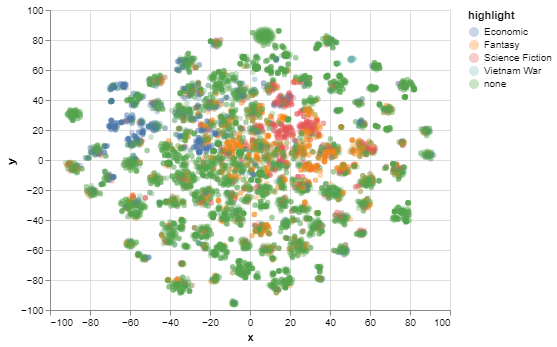

In [207]:
alt.Chart(combined_output).mark_circle(opacity=0.3).encode(
    alt.X('x'),
    alt.Y('y'),
    alt.Color('highlight'))

In [208]:
combined_output.to_csv('nodes.csv', index=False)

In [209]:
import plotly.graph_objs as go

In [152]:
tsne_df = pd.read_csv("nodes.csv")

data = []
for idx, val in tsne_df.groupby(tsne_df.highlight):
    if id
    highlight = idx

    scatter = go.Scatter3d(
        name=f"Class {highlight}",
        x=val["x"],
        y=val["y"],
        z=val["z"],
        mode="markers",
        marker=dict(size=2.5, symbol="circle-open"),
    )
    data.append(scatter)

In [ ]:
def tsne_to_cyto(tsne_val, scale_factor=40):
    return int(scale_factor * (float(tsne_val)))

In [85]:
def get_node_list(in_df):  # Convert DF data to node list for cytoscape
    return [
        {
            "data": {
                "id": str(i),
                "label": str(i),
                "category": row["category"],
                "mechanic": row["mechanic"]
                #"title": row["title"],
                #"journal": row["journal"],
                #"pub_date": row["pub_date"],
                #"authors": row["authors"],
                #"cited_by": row["cited_by"],
                #"n_cites": row["n_cites"],
                #"node_size": int(np.sqrt(1 + row["n_cites"]) * 10),
            },
            "position": {"x": row["comp1"], "y": row["comp2"]},
            "classes": row["highlight"],
            "selectable": True,
            "grabbable": False,
        }
        for i, row in in_df.iterrows()
    ]

In [ ]:
def draw_edges(in_df):
    conn_list_out = list()

    for i, row in in_df.iterrows():
        highlights = row["category"]

        #if len(highlights) == 0:
        #    citations_list = []
        #else:
        #    citations_list = citations.split(",")

        for high in highlights:
            if int(high) in in_df.index:
                tgt_topic = row["topic_id"]
                temp_dict = {
                    "data": {"source": cit, "target": str(i)},
                    "classes": tgt_topic,
                    "tgt_topic": tgt_topic,
                    "src_topic": in_df.loc[int(cit), "topic_id"],
                    "locked": True,
                }
                conn_list_out.append(temp_dict)

    return conn_list_out

In [95]:
node_list = get_node_list(combined_output)

In [98]:
startup_elms = {"elm_list" : node_list}

In [100]:
with open("startup_elms.json", "w") as f:
    json.dump(startup_elms, f)

In [94]:
col_swatch = px.colors.qualitative.Dark24

In [29]:
# low explained variance

In [30]:
components_output = pd.DataFrame(pca_results.components_).transpose()

In [31]:
output_df = pd.concat([components_output, pd.Series(kmeans.labels_)], axis = 1)

In [32]:
output_df.columns = ['pc1', 'pc2', 'pc3', 'kmeans_category']

In [33]:
output_df

,pc1,pc2,pc3,kmeans_category
0,0.010806,0.000753,0.002365,4
1,0.009722,0.008656,-0.003303,0
2,0.009973,0.007751,-0.004939,6
3,0.008237,0.001644,-0.005165,6
4,0.008920,0.005491,-0.004576,4
...,...,...,...,...
10527,0.008564,-0.014257,-0.013072,1
10528,0.014270,0.014135,0.020933,2
10529,0.011442,0.015178,-0.006645,2
10530,0.007541,-0.002677,0.002525,6


In [34]:
output_df.kmeans_category = output_df.kmeans_category.astype(str)

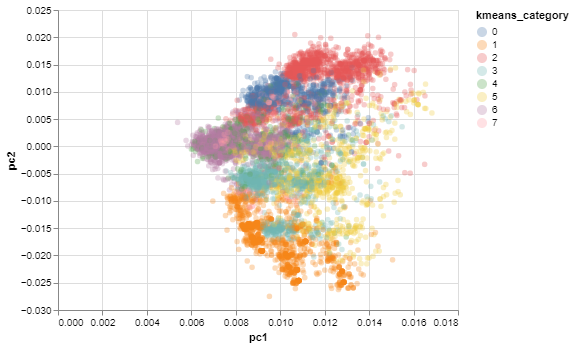

In [35]:
alt.Chart(output_df).mark_circle(opacity=0.3).encode(
    alt.X('pc1'),
    alt.Y('pc2'),
    alt.Color('kmeans_category'))

In [36]:
# note that the categories were fit on prior to the PCA therefore, even though the PCA doesn't segregate the data nicely
# doesn't mean that the categories are not meaningful
# likely requires some exploration of the features/games in relation to the categories to understand if the clustering is meaningful
# however, to get a useful 'recommender' from the anlaysis in connection with a visual, will need to use the PCAs
# or make a note that the recommended boardgame is based on closest distance metric used within it's class 
# which may be difference which may not line up perfectly with the visual distance

In [ ]:
# scratch work below when trying to get a pipeline to work
# ignore for now

In [99]:
t = [('num', Normalizer('l1'), num_cols)]
col_transform = ColumnTransformer(transformers = t)

In [100]:
model = KMeans(n_clusters = 10, n_init = 1000)

In [101]:
pipeline = Pipeline(steps=[('prep', col_transform), ('m', model)])

In [102]:
pipeline

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', Normalizer(norm='l1'),
                                                  ['average_rating',
                                                   'users_rated'])])),
                ('m', KMeans(n_clusters=10, n_init=1000))])

In [104]:
kmeans = pipeline.fit(X = new_df, y = None)

In [106]:
kmeans.labels_

AttributeError: 'Pipeline' object has no attribute 'labels_'